Importing neccessary libraries

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.regularizers import l2

Load Dataset

We use dataset from Yahoo Finance.

In [2]:
data = yf.download('BTC-USD', start='2010-01-01', end='2024-10-22')

[*********************100%***********************]  1 of 1 completed


Displays a portion of the data.

In [3]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-10-17,67617.078125,67912.210938,66647.390625,67399.835938,67399.835938,32790898511
2024-10-18,67419.109375,68969.750000,67177.820312,68418.789062,68418.789062,36857165014
2024-10-19,68418.976562,68668.007812,68024.640625,68362.734375,68362.734375,14443497908
2024-10-20,68364.179688,69359.007812,68105.718750,69001.703125,69001.703125,18975847518
2024-10-21,69002.000000,69462.734375,66829.851562,67367.851562,67367.851562,37498611780


In [4]:
data = data.reset_index()

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3688 entries, 0 to 3687
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3688 non-null   datetime64[ns]
 1   Open       3688 non-null   float64       
 2   High       3688 non-null   float64       
 3   Low        3688 non-null   float64       
 4   Close      3688 non-null   float64       
 5   Adj Close  3688 non-null   float64       
 6   Volume     3688 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 201.8 KB


**DATA PREPROCESSING**

Doing some feature selection and engineering.

Calculate some period of EMA using Close price.

In [7]:
data['EMA7'] = data['Close'].ewm(span=7, adjust=False).mean()
data['EMA14'] = data['Close'].ewm(span=14, adjust=False).mean()
data['EMA20'] = data['Close'].ewm(span=20, adjust=False).mean()
data['EMA50'] = data['Close'].ewm(span=50, adjust=False).mean()
data['EMA200'] = data['Close'].ewm(span=200, adjust=False).mean()

Calculate RSI using Close price.

In [10]:
def compute_rsi(data, window=14):
    delta = data['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

data['RSI'] = compute_rsi(data)

Calculate Bollinger Bands using EMA20 and Close price.

In [11]:
data['Upper_Band'] = data['EMA20'] + 2 * data['Close'].rolling(window=20).std()
data['Lower_Band'] = data['EMA20'] - 2 * data['Close'].rolling(window=20).std()

Calculate On Balance Volume using Close price and volume transaction.

In [12]:
data['OBV'] = (np.sign(data['Close'].diff()) * data['Volume']).cumsum()

In [13]:
data['OBV'] = data['OBV'].ffill()
data = data.dropna()

In [14]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Log_Close,EMA7,EMA14,EMA20,EMA50,EMA200,RSI,Upper_Band,Lower_Band,OBV
19,2014-10-06,320.389008,345.134003,302.559998,330.079010,330.079010,79011800,5.799332,349.294184,370.852860,383.883180,416.314470,444.795912,30.138935,455.000513,312.765847,-238669296.0
20,2014-10-07,330.584015,339.247009,320.481995,336.187012,336.187012,49199900,5.817668,346.017391,366.230747,379.340688,413.172217,443.715227,17.642549,446.822280,311.859096,-189469396.0
21,2014-10-08,336.115997,354.364014,327.187988,352.940002,352.940002,54736300,5.866298,347.748044,364.458648,376.826337,410.810169,442.811990,27.775351,442.813717,310.838957,-134733096.0
22,2014-10-09,352.747986,382.726013,347.687012,365.026001,365.026001,83641104,5.899969,352.067533,364.534295,375.702495,409.014712,442.038001,35.319233,441.654040,309.750950,-51091992.0
23,2014-10-10,364.687012,375.066986,352.963013,361.562012,361.562012,43665700,5.890434,354.441153,364.137990,374.355783,407.153822,441.237244,36.159745,439.144468,309.567098,-94757692.0


Plotting some features.

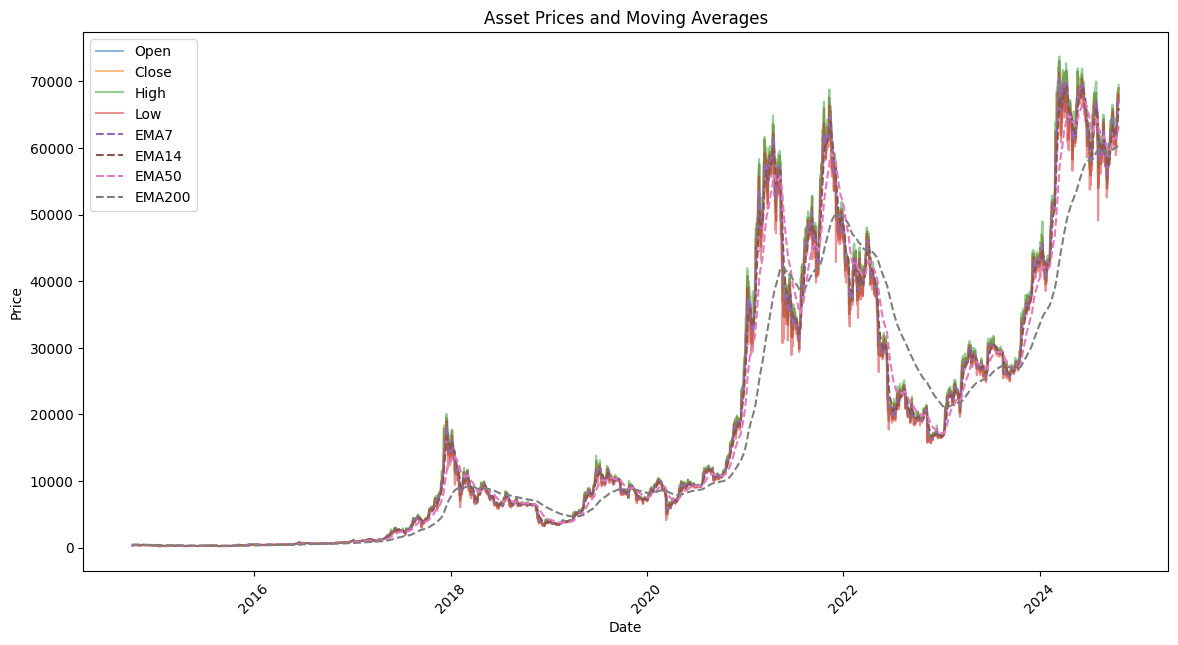

In [15]:
# Plotting the data
plt.figure(figsize=(14, 7))

# Plot Open, Close, High, Low prices
plt.plot(data['Date'], data['Open'], label='Open', alpha=0.5)
plt.plot(data['Date'], data['Close'], label='Close', alpha=0.5)
plt.plot(data['Date'], data['High'], label='High', alpha=0.5)
plt.plot(data['Date'], data['Low'], label='Low', alpha=0.5)

# Plot Moving Averages
plt.plot(data['Date'], data['EMA7'], label='EMA7', linestyle='--')
plt.plot(data['Date'], data['EMA14'], label='EMA14', linestyle='--')
plt.plot(data['Date'], data['EMA50'], label='EMA50', linestyle='--')
plt.plot(data['Date'], data['EMA200'], label='EMA200', linestyle='--')

# Add titles and labels
plt.title('Asset Prices and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

Define the features and target that will be used.

In [16]:
# Create the target variable (next day's closing price)
data['Target'] = data['Close'].shift(-1)
data = data.dropna()

In [17]:
# Select features and target
features = data[['Open', 'Low', 'High', 'Close', 'Volume', 'EMA7', 'EMA14', 'EMA50', 'EMA200', 'RSI', 'Upper_Band', 'Lower_Band', 'OBV']]
target = data['Target']

In [18]:
# Normalize the features for LSTM
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)
target = target.values.reshape(-1, 1)
target_scaled = scaler.fit_transform(target)

Convert features and targets into sequences and split the training data and testing data.

In [19]:
def create_sequences(features, target, n_steps):
    X, y = [], []
    for i in range(len(features) - n_steps):
        X.append(features[i:i + n_steps])
        y.append(target[i + n_steps])
    return np.array(X), np.array(y)

# Define the sequence length (e.g., 60 days)
n_steps = 30

X, y = create_sequences(features_scaled, target_scaled, n_steps)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (2910, 30, 13)
y_train shape: (2910, 1)
X_test shape: (728, 30, 13)
y_test shape: (728, 1)


**BUILD THE MODEL**

We define a custom LSTM architecture using Keras.

In [22]:
# Build the LSTM model
LSTM_model = Sequential()
LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(0.001)))
LSTM_model.add(Dropout(0.2))
LSTM_model.add(LSTM(units=64, return_sequences=True))
LSTM_model.add(Dropout(0.2))
LSTM_model.add(LSTM(units=32, return_sequences=False))
LSTM_model.add(Dense(units=50, activation='relu'))
LSTM_model.add(Dense(units=10, activation='relu'))
LSTM_model.add(Dense(units=1))

# Compile the model
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0005)
LSTM_model.compile(optimizer=optimizer, loss='mean_squared_error')

# Add early stopping based on validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = LSTM_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])  

Epoch 1/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0439 - val_loss: 0.0211
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0207 - val_loss: 0.0167
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0159 - val_loss: 0.0123
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0122 - val_loss: 0.0122
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0094 - val_loss: 0.0094
Epoch 6/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0079 - val_loss: 0.0069
Epoch 7/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0067 - val_loss: 0.0056
Epoch 8/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0058 - val_loss: 0.0053
Epoch 9/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0048 - val_loss: 0.0040
Epoch 10/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0045 - val_loss: 0.0038
Epoch 11/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0040 - val_loss: 0.0042
Epoch 12/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss:

**MODEL EVALUATION**

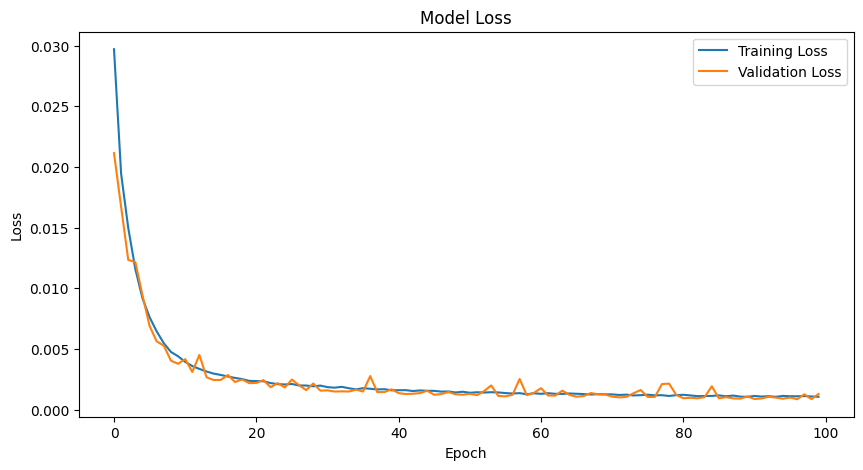

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Finally, we show how to make predictions on next day closing price.

In [26]:
# Define the number of steps
n_steps = 30

# Calculate the end index
end_index = len(features_scaled) - 1  

# Calculate the start index to include `n_steps` rows
start_index = end_index - n_steps + 1 

# Extract the sequence of `n_steps` rows
sequence = features_scaled[start_index:end_index + 1]  

# Check the shape of the sequence
print(f'Sequence shape: {sequence.shape}')

# Prepare the data point for the model
# Ensure the shape is (1, n_steps, number_of_features)
data_point = np.expand_dims(sequence, axis=0)

# Make the prediction
predicted_scaled = LSTM_model.predict(data_point)

# Reshape predicted_scaled to (1, 1) before inverse transforming
predicted_scaled_reshaped = predicted_scaled.reshape(-1, 1)

# Inverse transform the prediction to get the original scale
predicted = scaler.inverse_transform(predicted_scaled_reshaped)

print(f'Predicted closing price for the next day: {predicted[0][0]}')

Sequence shape: (30, 13)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted closing price for the next day: 67803.8203125
